In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")


In [3]:
df.head(3)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1


### Data preparation
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
# Check null values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [6]:
list(df.dtypes[df.dtypes != 'object'].index)

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [7]:
numerical = ['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [8]:
for c in categorical:
    df[c] = df[c].fillna('NA')
    
for n in numerical:
    df[n] = df[n].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split function for that with random_state=1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [12]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### QUESTION 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [13]:
auc_scores = {}

for col in numerical:
   auc = roc_auc_score(y_train, df_train[col])
    
   # If AUC <0.5, invert the feature direction
   if auc < 0.5:
      auc =  roc_auc_score(y_train, -df_train[col])
    
   auc_scores[col] = auc

In [14]:
# Sort by AUC descending
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

for col, auc in sorted_auc:
    print(f"{col}: {auc:.3f}")

number_of_courses_viewed: 0.764
interaction_count: 0.738
lead_score: 0.614
annual_income: 0.552


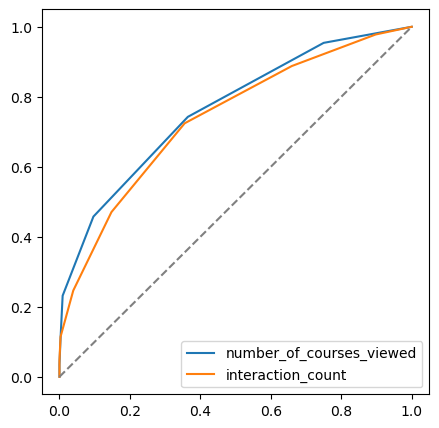

In [15]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.number_of_courses_viewed)
plt.plot(fpr, tpr, label='number_of_courses_viewed')

fpr, tpr, _ = roc_curve(y_train, df_train.interaction_count)
plt.plot(fpr, tpr, label='interaction_count')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

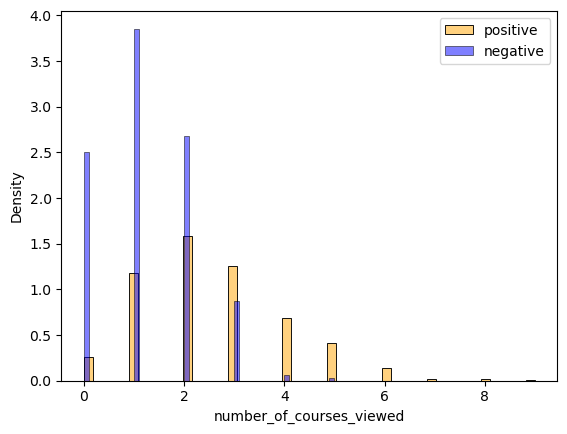

In [16]:
sns.histplot(df_train.number_of_courses_viewed[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.number_of_courses_viewed[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

### QUESTION 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

- LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)



In [17]:
# Prepare training data
train_dict = df_train.to_dict(orient='records')

# Fit DictVectorizer on training data
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

# Prepare validation data
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [18]:
# Train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Get the predictions using validation dataset and calculate AUC
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f"AUC on validation dataset: {auc:.3f}")   

AUC on validation dataset: 0.817


### QUESTION 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [19]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store precision and recall values
precisions = []
recalls = []

# For each threshold, compute precision and recall
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall. Use zero_division=0 to handle cases where there are no positive predictions
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)


Notes:
- If the predicted probability is greater than or equal to the current threshold, the prediction is 1 (positive class); otherwise, it's 0 (negative class). 
- The .astype(int) converts the boolean result (True/False) to an integer (1/0).

In [20]:
# Turn precisions and recalls scores into a numpy array for easier computation
precisions = np.array(precisions)
recalls = np.array(recalls)


In [21]:
mask = (precisions > 0.1) & (recalls > 0.1)
valid_thresholds = thresholds[mask]
valid_precisions = precisions[mask]
valid_recalls = recalls[mask]

intersection_idx = np.argmin(np.abs(valid_precisions - valid_recalls))
intersection_threshold = valid_thresholds[intersection_idx]
intersection_value = valid_precisions[intersection_idx]

print(f"Threshold (x) = {intersection_threshold:.3f}")
print(f"Precision = Recall (y) = {intersection_value:.3f}")
print(f"Point = ({intersection_threshold:.3f}, {intersection_value:.3f})")

Threshold (x) = 0.640
Precision = Recall (y) = 0.779
Point = (0.640, 0.779)


Notes:
- mask = (precisions > 0.1) & (recalls > 0.1): This creates a Boolean mask to filter out points where both precision and recall are very low (less than 0.1). This step is often used to ignore uninformative or noisy parts of the curve where the model performance is very poor.

- valid_thresholds = thresholds[mask], etc.: This applies the mask to keep only the valid thresholds, precisions, and recalls that meet the $0.1$ performance floor.

- np.abs(valid_precisions - valid_recalls) calculates the absolute difference between Precision and Recall at every valid point.

- np.argmin(...) finds the index of the smallest absolute difference. This index corresponds to the point where Precision and Recall are closest to each other.

- intersection_threshold = valid_thresholds[intersection_idx], etc.: The values for the threshold, precision, and recall at this optimal balance point are extracted using the found index.


**This process essentially mimics finding the point on a Precision-Recall Curve that is closest to the line $y=x$, indicating the best trade-off between minimizing False Positives (Precision concern) and minimizing False Negatives (Recall concern).**

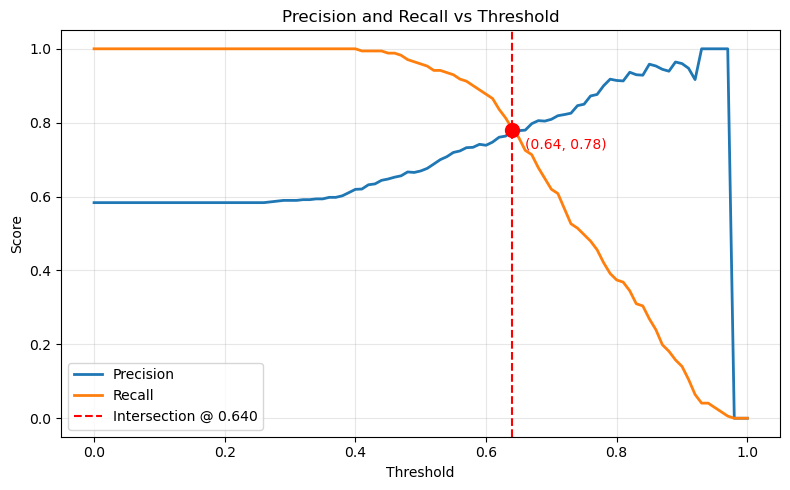

In [22]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

plt.axvline(intersection_threshold, color='red', linestyle='--', label=f'Intersection @ {intersection_threshold:.3f}')
plt.scatter(intersection_threshold, intersection_value, color='red', s=100, zorder=5)
plt.text(intersection_threshold + 0.02, intersection_value - 0.05,
         f"({intersection_threshold:.2f}, {intersection_value:.2f})",
         color='red', fontsize=10)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### QUESTION 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 ⋅ (P⋅R) / (P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [23]:
y_pred_proba

array([0.57539503, 0.47060771, 0.61901239, 0.61438923, 0.61741033,
       0.6749675 , 0.84653511, 0.38205018, 0.5573536 , 0.91246752,
       0.77549361, 0.66110423, 0.91574387, 0.38389186, 0.88197524,
       0.89511779, 0.6533637 , 0.5307765 , 0.73106704, 0.70418458,
       0.78080322, 0.51381846, 0.88869814, 0.72195816, 0.91633087,
       0.53483933, 0.50123086, 0.84175874, 0.48497481, 0.60635466,
       0.63002391, 0.50197708, 0.54916066, 0.91861629, 0.6902664 ,
       0.65666095, 0.84766045, 0.79947506, 0.47461071, 0.63286016,
       0.82887381, 0.43559071, 0.45453633, 0.58816794, 0.64477417,
       0.73619001, 0.53893929, 0.71596384, 0.74170518, 0.86747809,
       0.77685779, 0.75943833, 0.84663025, 0.67334215, 0.78059003,
       0.68835979, 0.63561828, 0.56955799, 0.6699862 , 0.75372268,
       0.33388226, 0.68155643, 0.35336535, 0.7745121 , 0.51403965,
       0.26200893, 0.66844164, 0.41567481, 0.49375721, 0.54251897,
       0.85677057, 0.39794255, 0.46701361, 0.85106565, 0.77222

In [24]:
f1_scores = []

# For each threshold, compute F1 score
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    f1_scores.append(f1)

In [25]:
# Find the threshold with the maximum F1 score
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]
best_f1 = f1_scores[max_f1_idx]

print(f"Maximum F1 score = {best_f1:.3f} at threshold ≈ {best_threshold:.3f}")

Maximum F1 score = 0.812 at threshold ≈ 0.570


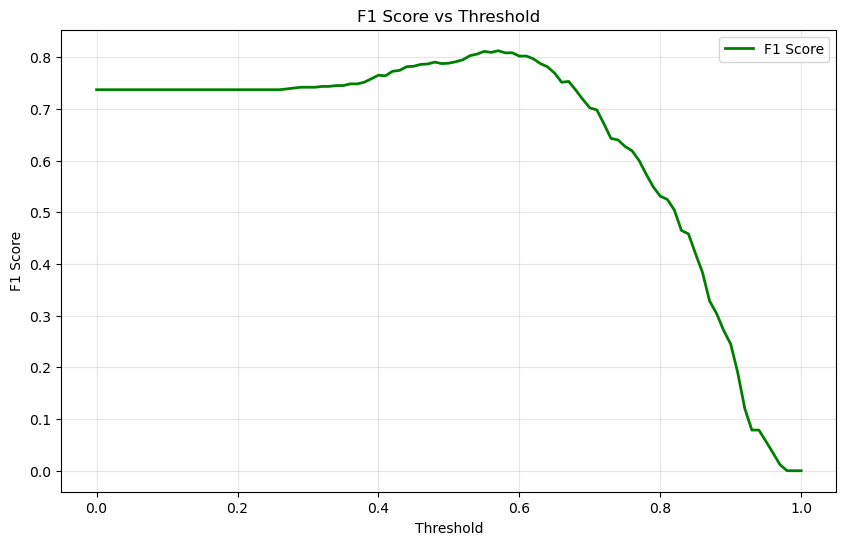

In [26]:
# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### QUESTION 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [27]:
# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [28]:
# List to store AUC scores for each fold
auc_scores = []

# Iterate over different folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # Split the data into train and validation
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    # Prepare training data
    y_train_fold = df_train_fold['converted'].values
    train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
    
    # Fit DictVectorizer and transform training data
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Prepare validation data
    y_val_fold = df_val_fold['converted'].values
    val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
    X_val_fold = dv.transform(val_dict)
    
    # Predict and calculate AUC
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.3f}")

Fold 1: AUC = 0.806
Fold 2: AUC = 0.871
Fold 3: AUC = 0.775
Fold 4: AUC = 0.802
Fold 5: AUC = 0.856


In [29]:
# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nMean AUC: {mean_auc:.3f}")
print(f"Standard deviation: {std_auc:.3f}")


Mean AUC: 0.822
Standard deviation: 0.036


### QUESTION 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
results = {}

# contains values for C (C=1.0) for questions 5 and 6 (C=[0.01, 0.1, 0.5, 10])
for C in [0.000001, 0.001, 1]:
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
        #Split folds
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values

        df_train_fold = df_train_fold.drop('converted', axis=1)
        df_val_fold = df_val_fold.drop('converted', axis=1)
        
        # One-hot encode
        dv = DictVectorizer(sparse=False)
        
        train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
        X_train_fold = dv.fit_transform(train_dict)
        
        val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
        X_val_fold = dv.transform(val_dict)

        # Train Logistic Regression
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Predict and evaluate AUC
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
    
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    results[C] = {'mean': round(mean_auc, 3), 'std': round(std_auc, 3)}
    
    print(f"C={C}: mean AUC={mean_auc:.3f}, std={std_auc:.3f}")

C=1e-06: mean AUC=0.560, std=0.024
C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036


In [33]:
best_C = sorted(results.items(), key=lambda x: (-x[1]['mean'], x[1]['std'], x[0]))[0]

print("\n==============================")
print(f"Best C value: {best_C[0]}")
print(f"Mean AUC: {best_C[1]['mean']:.3f} ± {best_C[1]['std']:.3f}")
print("==============================")


Best C value: 0.001
Mean AUC: 0.867 ± 0.029
